# Kaggle Integration

In [ ]:
!pip install kaggle

In [ ]:
!mkdir .kaggle

In [ ]:
import json
token = {"username":"xxx","key":"xxx"} # Put your kaggle username and token key

# upload your kaggle API token file and execute:
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [ ]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!kaggle config set -n path -v{/content}

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

# Downloading Dataset Through API

In [ ]:
!kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset -p /content

 95% 314M/330M [00:04<00:00, 103MB/s] 
100% 330M/330M [00:04<00:00, 71.5MB/s]


In [ ]:
!unzip \*.zip

# Packages

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from warnings import filterwarnings
filterwarnings("ignore")
import os

# Paths

In [ ]:
HEIGHT = 120
WEIGHT = 120

In [ ]:
train_dirs = ["/content/Face Mask Dataset/Train"]
test_dirs = ["/content/Face Mask Dataset/Test"]
validation_dirs = ["/content/Face Mask Dataset/Validation"]

In [ ]:
fullimg = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        fullimg.append(os.path.join(dirname, filename))

# Preprocessing

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_generator = ImageDataGenerator(rescale=1./255,
                                         zoom_range=0.2,
                                         shear_range=0.2,
                                         rotation_range=0.2)

test_data_generator = ImageDataGenerator(rescale=1./255)

validation_data_generator = ImageDataGenerator(rescale=1./255,
                                         zoom_range=0.2,
                                         shear_range=0.2)

In [ ]:
print("Flowing Train")
train_generator = train_data_generator.flow_from_directory(
        train_dirs[0],
        target_size=(HEIGHT,WEIGHT),
        batch_size=77,
        interpolation="nearest",
        class_mode='binary',
        classes=["WithoutMask","WithMask"])

print("\nFlowing Test")
test_generator = test_data_generator.flow_from_directory(
        test_dirs[0],
        target_size=(HEIGHT,WEIGHT),
        batch_size=66,
        interpolation="nearest",
        class_mode='binary',
        classes=["WithoutMask","WithMask"])
print("\nFlowing Validation")
validation_generator = validation_data_generator.flow_from_directory(
        validation_dirs[0],
        target_size=(HEIGHT,WEIGHT),
        batch_size=80,
        interpolation="nearest",
        class_mode='binary',
        classes=["WithoutMask","WithMask"])
withWithoutMask = {"0":"Without Mask","1":"With Mask"}

Flowing Train
Found 10000 images belonging to 2 classes.

Flowing Test
Found 992 images belonging to 2 classes.

Flowing Validation
Found 800 images belonging to 2 classes.


In [ ]:
def genToTuple(gen):
    templist = []
    templist2 = []
    for i in range(gen.__len__()):
        tempnext = gen.next()
        templist.append(tempnext[0])
        templist2.append(tempnext[1])
    x=np.concatenate(templist)
    y=np.concatenate(templist2)
    return (x,y)
    
train_generator_t = genToTuple(train_generator)
test_generator_t = genToTuple(test_generator)

x_train,y_train = train_generator_t
x_test,y_test = test_generator_t

x_val,y_val = genToTuple(validation_generator)

In [ ]:
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)
print(x_val.shape,y_val.shape)

(10000, 120, 120, 3) (10000,)
(992, 120, 120, 3) (992,)
(800, 120, 120, 3) (800,)


# Model Building

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dropout, SpatialDropout2D, BatchNormalization, Input, Activation, Dense, Flatten
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.utils import plot_model
from keras.losses import binary_crossentropy

def build_model():
        model = Sequential()
        
        model.add(Input(shape=(HEIGHT,WEIGHT,3,)))

        model.add(Conv2D(filters=16,kernel_size=(2,2),padding="same"))
        model.add(Activation("relu"))
        model.add(SpatialDropout2D(0.25))
        
        model.add(MaxPool2D(pool_size=(4,4)))

        model.add(Conv2D(filters=32,kernel_size=(2,2),padding="same"))
        model.add(Activation("relu"))
        model.add(SpatialDropout2D(0.25))
        
        model.add(MaxPool2D(pool_size=(4,4),strides=(4,4)))
               
        model.add(Flatten())
        
        model.add(Dense(2048))
        model.add(Activation("relu"))
        model.add(Dropout(0.25))
        
        model.add(Dense(1024))
        model.add(Activation("relu"))
        model.add(Dropout(0.2))
        
        
        model.add(Dense(1))
        model.add(Activation("sigmoid"))
        
        optimizer = Adam(lr=0.001)
        model.compile(optimizer = optimizer ,metrics=["accuracy"], loss = binary_crossentropy)
        
        return model

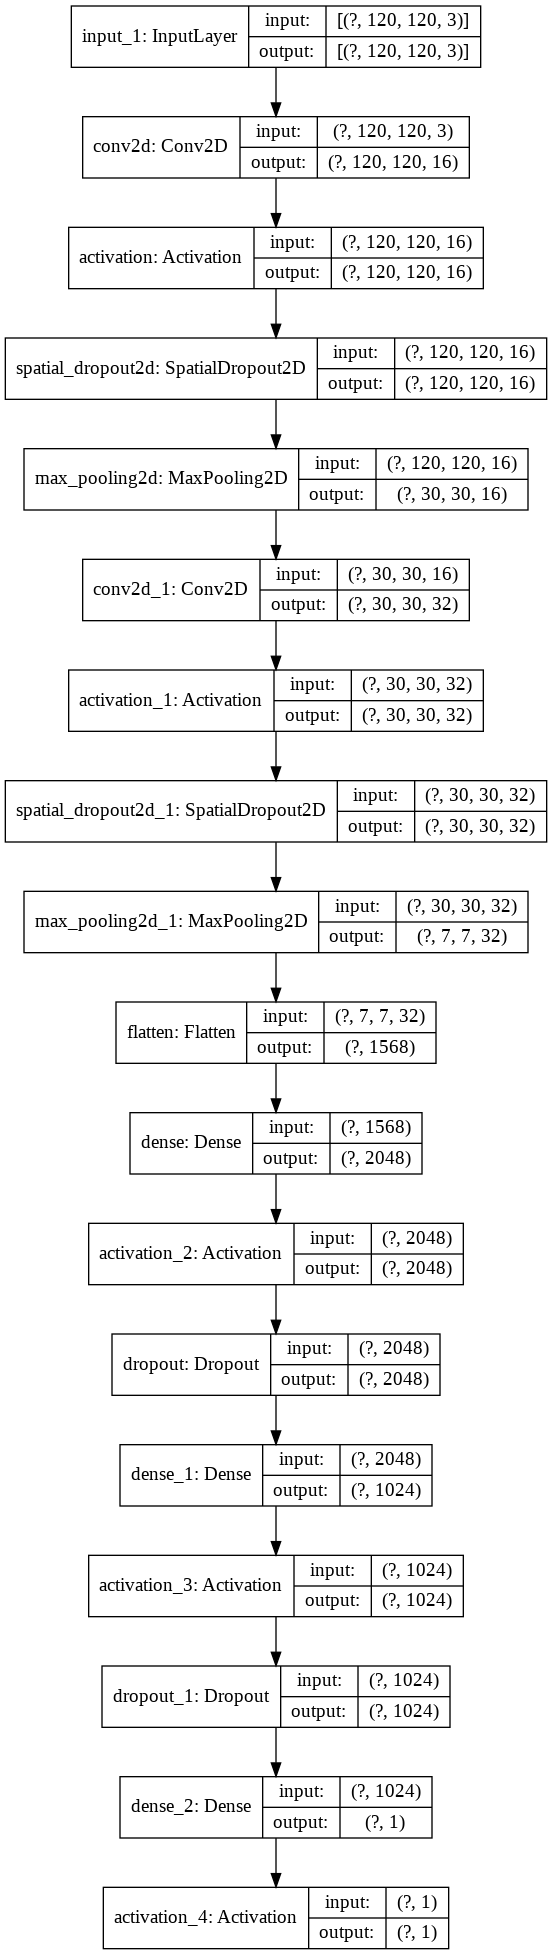

In [ ]:
model = build_model()
plot_model(model,show_shapes=True,show_layer_names=True)

# Model Training

In [ ]:
reducer = ReduceLROnPlateau(monitor='loss',patience=3,factor=0.75,min_lr=0.000001,verbose=1)
stopSign = EarlyStopping(monitor = "loss",patience=20,min_delta=0.000000000001,mode="min")

epochs = 200
batch_size = 32
steps_per_epoch = x_train.shape[0] // batch_size
history = model.fit(x_train,y_train,
                    epochs = epochs, 
                    validation_data = (x_val,y_val),
                    verbose = 1,
                    batch_size=batch_size,
                    steps_per_epoch = steps_per_epoch,
                    callbacks=[reducer,stopSign])

Epoch 1/200
312/312 [==============================] - 73s 233ms/step - loss: 0.0883 - accuracy: 0.9676 - val_loss: 0.0381 - val_accuracy: 0.9875
Epoch 2/200
312/312 [==============================] - 72s 231ms/step - loss: 0.0648 - accuracy: 0.9764 - val_loss: 0.0494 - val_accuracy: 0.9887
Epoch 3/200
312/312 [==============================] - 72s 231ms/step - loss: 0.0648 - accuracy: 0.9765 - val_loss: 0.0280 - val_accuracy: 0.9925
Epoch 4/200
312/312 [==============================] - 75s 239ms/step - loss: 0.0606 - accuracy: 0.9782 - val_loss: 0.0251 - val_accuracy: 0.9950
Epoch 5/200
312/312 [==============================] - 72s 232ms/step - loss: 0.0499 - accuracy: 0.9817 - val_loss: 0.0250 - val_accuracy: 0.9912
Epoch 6/200
312/312 [==============================] - 72s 229ms/step - loss: 0.0419 - accuracy: 0.9851 - val_loss: 0.0212 - val_accuracy: 0.9937
Epoch 7/200
312/312 [==============================] - 72s 230ms/step - loss: 0.0389 - accuracy: 0.9866 - val_loss: 0.0228 -

# Prediction Accuracy

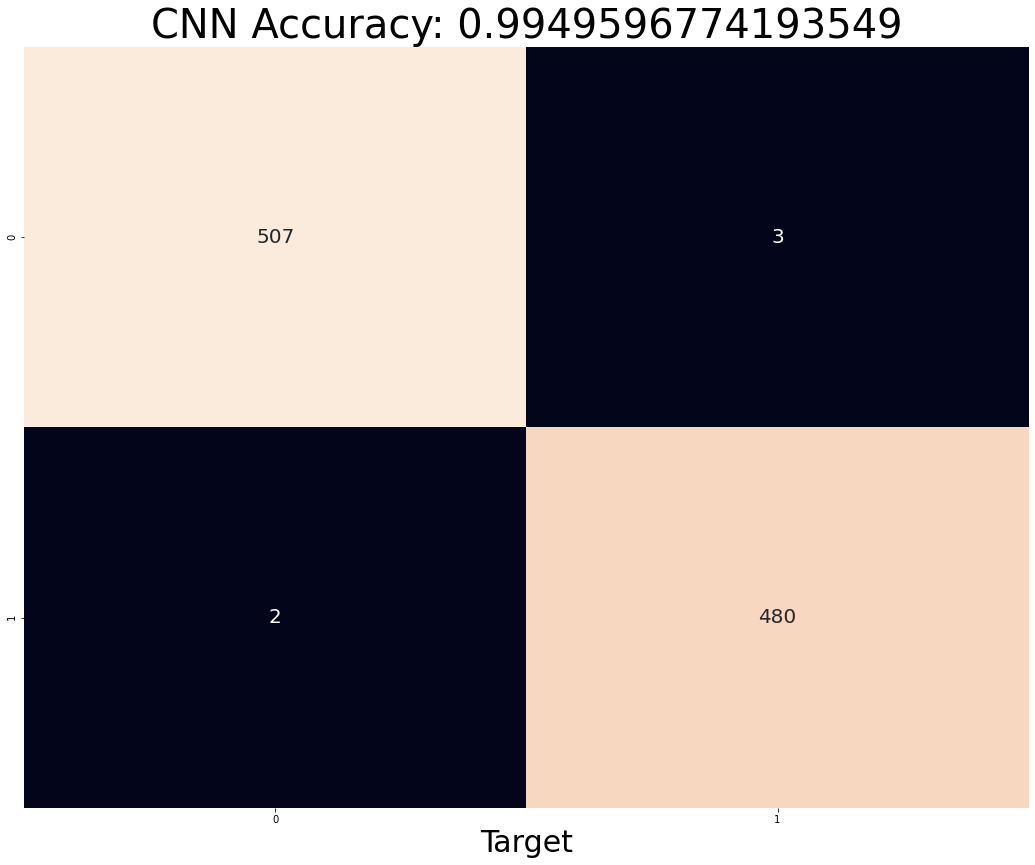

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

ypred = model.predict_classes(x_test)
plt.subplots(figsize=(18,14))
sns.heatmap(confusion_matrix(ypred,y_test),annot=True,fmt="1.0f",cbar=False,annot_kws={"size": 20})
plt.title(f"CNN Accuracy: {accuracy_score(ypred,y_test)}",fontsize=40)
plt.xlabel("Target",fontsize=30)
plt.show()

In [ ]:
y_test = y_test.astype(int)

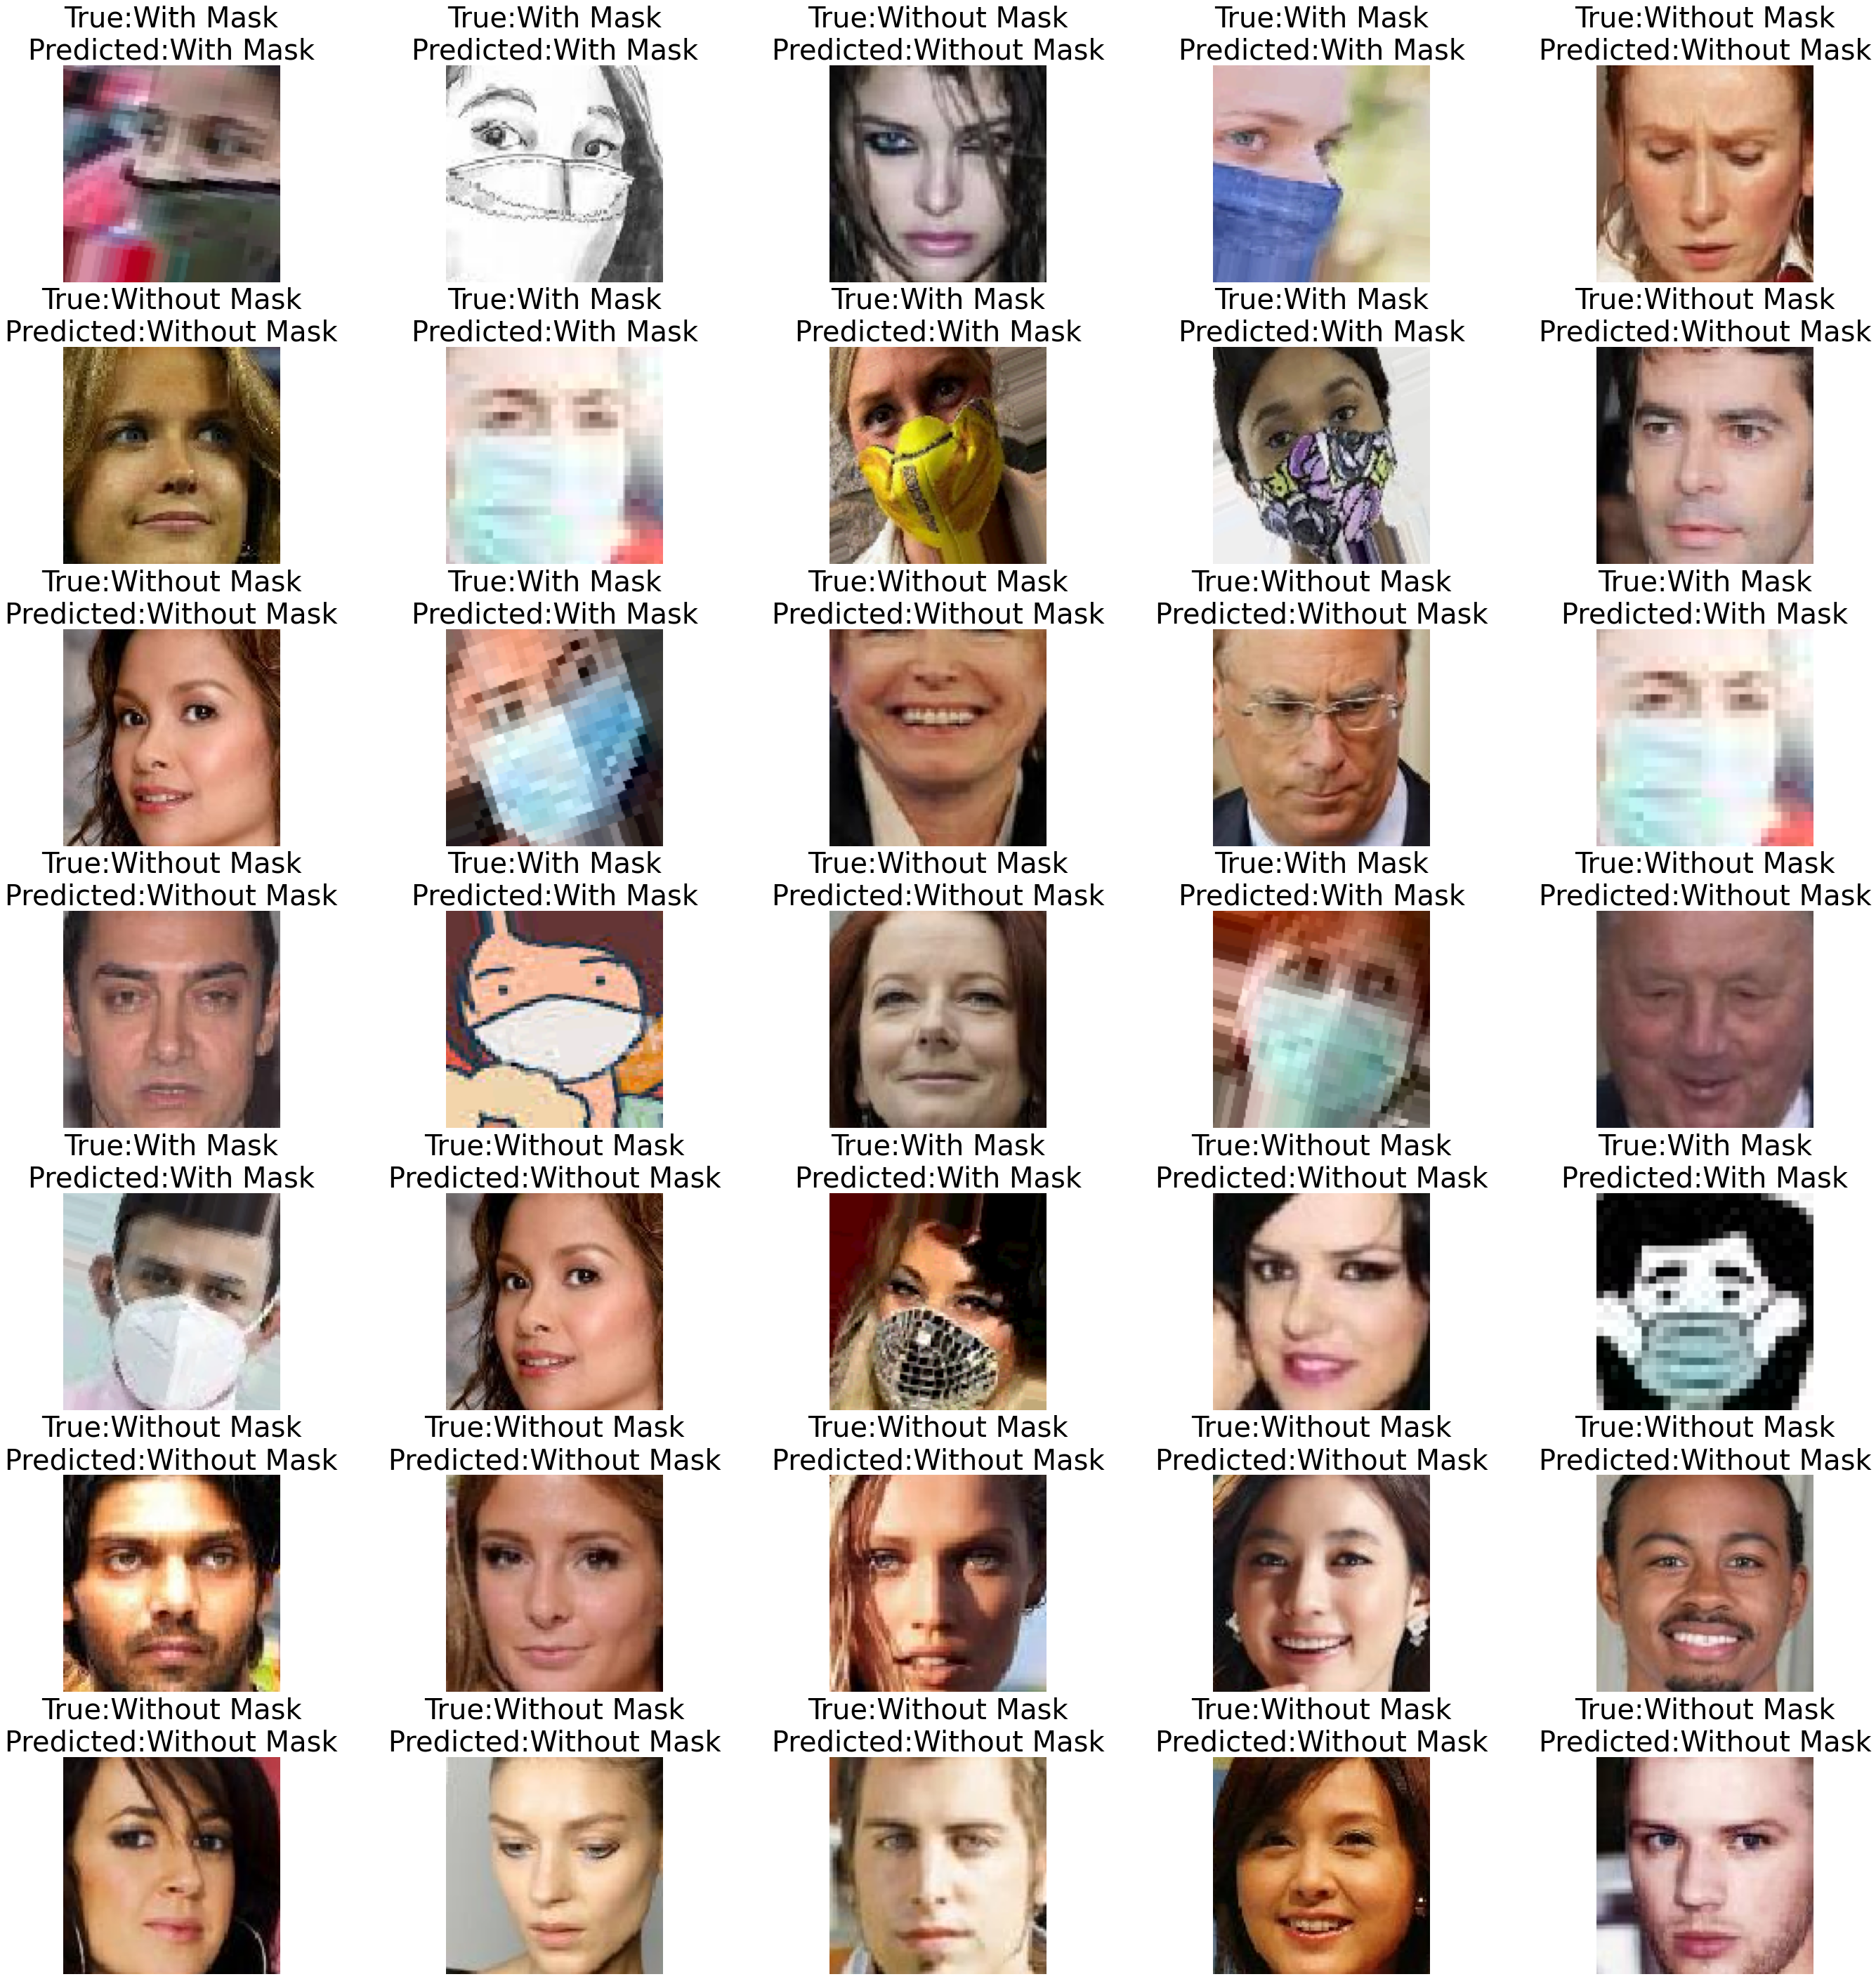

In [ ]:
plt.figure(figsize=(50,50))
tempc = np.random.choice(x_test[y_test == ypred.ravel()].shape[0],35,replace=False)
d = 0
for i in tempc:
    plt.subplot(7, 5, d+1)
    d += 1
    tempc = np.random.randint(x_test[y_test == ypred.ravel()].shape[0])
    plt.imshow(x_test[y_test == ypred.ravel()][tempc])
    plt.title(f"True:{withWithoutMask[str(y_test[y_test == ypred.ravel()][tempc])]}\nPredicted:{withWithoutMask[str(ypred.ravel()[y_test == ypred.ravel()][tempc])]}",fontsize=40)
    plt.axis("off")
plt.subplots_adjust(wspace=-0.1, hspace=0.3)
plt.show()

# Conclusion

A Convolutional Neural Network was implemented to classify images as 'With Mask' or 'Without Mask' in Python using Tensorflow and Kaggle dataset.

# Reference:
* [Kaggle Dataset: face-mask-12k-images](https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset)